<a href="https://colab.research.google.com/github/SanyaShresta25/Facial-Expression-Generation-Using-Gan-Autoencoder/blob/main/Facial_Expression_Generation_Labeled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# **Facial Expression Generation Using GAN and Autoencoder**
Generate new facial expressions from neutral images using CelebA dataset. Use GAN and
Autoencoder architectures. Explore six hyperparameters such as latent vector size, learning rate,
number of discriminator/encoder layers, optimizer, dropout, and batch size.

# **Setup**

In [2]:
# Mount Google Drive to save results
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install torchvision matplotlib


Mounted at /content/drive


# **Imports and Parameters**

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
image_size = 64
latent_dim = 64
lr = 0.0002
beta1 = 0.5
dropout_rate = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **Load CelebA Dataset (Smiling only)**

In [4]:
import zipfile
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
zip_path = "/content/drive/MyDrive/celeba/img_align_celeba.zip"
attr_path = "/content/drive/MyDrive/celeba/list_attr_celeba.txt"

# Params
image_size = 64
batch_size = 64

# Load attributes (skip the header)
attr_df = pd.read_csv(attr_path, sep="\s+", skiprows=1)
attr_df.replace(-1, 0, inplace=True)  # make values 0 or 1

# Filter for smiling images only (col 31 is "Smiling")
smiling_df = attr_df[attr_df['Smiling'].isin([0, 1])]

# Define transform
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Custom Dataset
class CelebAZipDataset(Dataset):
    def __init__(self, zip_path, attr_df, transform=None):
        self.zip_path = zip_path
        self.attr_df = attr_df
        self.transform = transform
        self.image_names = attr_df.index.tolist()
        self.zip_file = None  # will be opened lazily

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if self.zip_file is None:
            self.zip_file = zipfile.ZipFile(self.zip_path, 'r')

        img_name = f"img_align_celeba/{self.image_names[idx]}"
        attr = torch.tensor(self.attr_df.loc[self.image_names[idx]].values, dtype=torch.float32)

        with self.zip_file.open(img_name) as file:
            img = Image.open(file).convert('RGB')
            if self.transform:
                img = self.transform(img)

        return img, attr

# Dataset and DataLoader
dataset = CelebAZipDataset(zip_path, smiling_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Define Autoencoder**

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 64, 64))
        )

    def forward(self, x):
        return self.model(x)


# **Define Discriminator**

In [6]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),      # 64x32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),    # 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# **Train the Model**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-745bfd8e3281>:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_attr = pd.read_csv(attr_path, delim_whitespace=True, header=1)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████

[Epoch 1/8] [Batch 0/3166] [D loss: 1.4447] [G loss: 16.0354]
[Epoch 1/8] [Batch 100/3166] [D loss: 0.3531] [G loss: 17.1069]
[Epoch 1/8] [Batch 200/3166] [D loss: 0.3392] [G loss: 18.0581]
[Epoch 1/8] [Batch 300/3166] [D loss: 0.3505] [G loss: 18.9119]
[Epoch 1/8] [Batch 400/3166] [D loss: 0.3437] [G loss: 18.4735]
[Epoch 1/8] [Batch 500/3166] [D loss: 0.3357] [G loss: 18.4669]
[Epoch 1/8] [Batch 600/3166] [D loss: 0.3322] [G loss: 17.8761]
[Epoch 1/8] [Batch 700/3166] [D loss: 0.3375] [G loss: 17.5948]
[Epoch 1/8] [Batch 800/3166] [D loss: 0.3330] [G loss: 17.7830]
[Epoch 1/8] [Batch 900/3166] [D loss: 0.3411] [G loss: 17.5563]
[Epoch 1/8] [Batch 1000/3166] [D loss: 0.3435] [G loss: 17.8897]
[Epoch 1/8] [Batch 1100/3166] [D loss: 0.3299] [G loss: 17.4304]
[Epoch 1/8] [Batch 1200/3166] [D loss: 0.3294] [G loss: 17.0773]
[Epoch 1/8] [Batch 1300/3166] [D loss: 0.3408] [G loss: 17.4910]
[Epoch 1/8] [Batch 1400/3166] [D loss: 0.3300] [G loss: 17.5360]
[Epoch 1/8] [Batch 1500/3166] [D loss

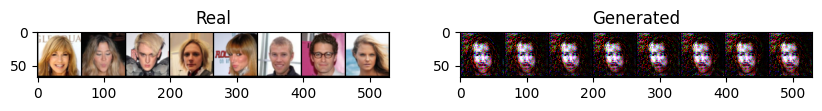

[Epoch 2/8] [Batch 0/3166] [D loss: 0.3306] [G loss: 17.3610]
[Epoch 2/8] [Batch 100/3166] [D loss: 0.3277] [G loss: 17.6183]
[Epoch 2/8] [Batch 200/3166] [D loss: 0.3281] [G loss: 18.3623]
[Epoch 2/8] [Batch 300/3166] [D loss: 0.3324] [G loss: 17.9791]
[Epoch 2/8] [Batch 400/3166] [D loss: 0.3285] [G loss: 17.9485]
[Epoch 2/8] [Batch 500/3166] [D loss: 0.3309] [G loss: 18.1184]
[Epoch 2/8] [Batch 600/3166] [D loss: 0.3265] [G loss: 18.3428]
[Epoch 2/8] [Batch 700/3166] [D loss: 0.3324] [G loss: 18.7224]
[Epoch 2/8] [Batch 800/3166] [D loss: 0.3261] [G loss: 18.6380]
[Epoch 2/8] [Batch 900/3166] [D loss: 0.3298] [G loss: 18.2378]
[Epoch 2/8] [Batch 1000/3166] [D loss: 0.3335] [G loss: 18.3132]
[Epoch 2/8] [Batch 1100/3166] [D loss: 0.3276] [G loss: 18.5739]
[Epoch 2/8] [Batch 1200/3166] [D loss: 0.3277] [G loss: 18.4997]
[Epoch 2/8] [Batch 1300/3166] [D loss: 0.3269] [G loss: 18.5720]
[Epoch 2/8] [Batch 1400/3166] [D loss: 0.3278] [G loss: 18.8613]
[Epoch 2/8] [Batch 1500/3166] [D loss

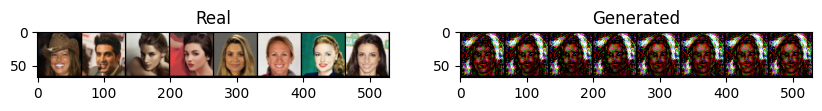

[Epoch 3/8] [Batch 0/3166] [D loss: 0.3273] [G loss: 18.9656]
[Epoch 3/8] [Batch 100/3166] [D loss: 0.3289] [G loss: 18.7256]
[Epoch 3/8] [Batch 200/3166] [D loss: 0.3264] [G loss: 19.6124]
[Epoch 3/8] [Batch 300/3166] [D loss: 0.3264] [G loss: 19.0669]
[Epoch 3/8] [Batch 400/3166] [D loss: 0.3296] [G loss: 19.0009]
[Epoch 3/8] [Batch 500/3166] [D loss: 0.3259] [G loss: 19.0132]
[Epoch 3/8] [Batch 600/3166] [D loss: 0.3281] [G loss: 19.4569]
[Epoch 3/8] [Batch 700/3166] [D loss: 0.3275] [G loss: 19.0626]
[Epoch 3/8] [Batch 800/3166] [D loss: 0.3275] [G loss: 19.5031]
[Epoch 3/8] [Batch 900/3166] [D loss: 0.3338] [G loss: 19.0297]
[Epoch 3/8] [Batch 1000/3166] [D loss: 0.3267] [G loss: 19.1814]
[Epoch 3/8] [Batch 1100/3166] [D loss: 0.3299] [G loss: 19.8110]
[Epoch 3/8] [Batch 1200/3166] [D loss: 0.3337] [G loss: 19.5620]
[Epoch 3/8] [Batch 1300/3166] [D loss: 0.3261] [G loss: 19.5259]
[Epoch 3/8] [Batch 1400/3166] [D loss: 0.3268] [G loss: 20.0017]
[Epoch 3/8] [Batch 1500/3166] [D loss

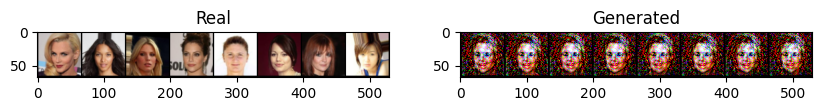

[Epoch 4/8] [Batch 0/3166] [D loss: 0.3319] [G loss: 19.2597]
[Epoch 4/8] [Batch 100/3166] [D loss: 0.3256] [G loss: 19.3226]
[Epoch 4/8] [Batch 200/3166] [D loss: 0.3254] [G loss: 19.9650]
[Epoch 4/8] [Batch 300/3166] [D loss: 0.3255] [G loss: 19.8976]
[Epoch 4/8] [Batch 400/3166] [D loss: 0.3262] [G loss: 19.8387]
[Epoch 4/8] [Batch 500/3166] [D loss: 0.3254] [G loss: 20.2819]
[Epoch 4/8] [Batch 600/3166] [D loss: 0.3254] [G loss: 20.2574]
[Epoch 4/8] [Batch 700/3166] [D loss: 0.3254] [G loss: 20.1958]
[Epoch 4/8] [Batch 800/3166] [D loss: 0.3254] [G loss: 20.1620]
[Epoch 4/8] [Batch 900/3166] [D loss: 0.3254] [G loss: 20.4235]
[Epoch 4/8] [Batch 1000/3166] [D loss: 0.3254] [G loss: 20.0486]
[Epoch 4/8] [Batch 1100/3166] [D loss: 0.3256] [G loss: 20.1554]
[Epoch 4/8] [Batch 1200/3166] [D loss: 0.3258] [G loss: 20.4787]
[Epoch 4/8] [Batch 1300/3166] [D loss: 0.3259] [G loss: 20.4068]
[Epoch 4/8] [Batch 1400/3166] [D loss: 0.3257] [G loss: 20.5293]
[Epoch 4/8] [Batch 1500/3166] [D loss

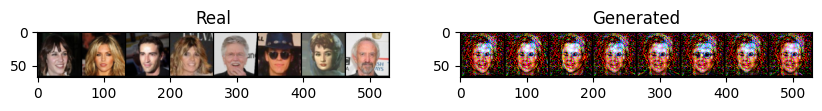

[Epoch 5/8] [Batch 0/3166] [D loss: 0.3261] [G loss: 20.4235]
[Epoch 5/8] [Batch 100/3166] [D loss: 0.3254] [G loss: 19.8921]
[Epoch 5/8] [Batch 200/3166] [D loss: 0.3262] [G loss: 20.2233]
[Epoch 5/8] [Batch 300/3166] [D loss: 0.3256] [G loss: 19.9829]
[Epoch 5/8] [Batch 400/3166] [D loss: 0.3253] [G loss: 19.9904]
[Epoch 5/8] [Batch 500/3166] [D loss: 0.3261] [G loss: 20.0404]
[Epoch 5/8] [Batch 600/3166] [D loss: 0.3254] [G loss: 19.8478]
[Epoch 5/8] [Batch 700/3166] [D loss: 0.3255] [G loss: 20.1912]
[Epoch 5/8] [Batch 800/3166] [D loss: 0.3256] [G loss: 20.3441]
[Epoch 5/8] [Batch 900/3166] [D loss: 0.3254] [G loss: 19.6992]
[Epoch 5/8] [Batch 1000/3166] [D loss: 0.3254] [G loss: 20.4150]
[Epoch 5/8] [Batch 1100/3166] [D loss: 0.3261] [G loss: 20.0724]
[Epoch 5/8] [Batch 1200/3166] [D loss: 0.3254] [G loss: 20.3043]
[Epoch 5/8] [Batch 1300/3166] [D loss: 0.3264] [G loss: 19.9979]
[Epoch 5/8] [Batch 1400/3166] [D loss: 0.3253] [G loss: 20.2896]
[Epoch 5/8] [Batch 1500/3166] [D loss

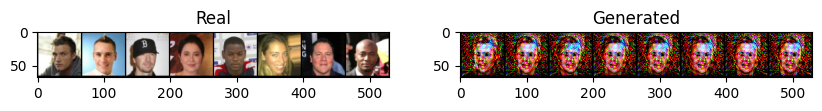

[Epoch 6/8] [Batch 0/3166] [D loss: 0.3259] [G loss: 20.5296]
[Epoch 6/8] [Batch 100/3166] [D loss: 0.3254] [G loss: 20.1975]
[Epoch 6/8] [Batch 200/3166] [D loss: 0.3255] [G loss: 19.7312]
[Epoch 6/8] [Batch 300/3166] [D loss: 0.3257] [G loss: 20.0069]
[Epoch 6/8] [Batch 400/3166] [D loss: 0.3254] [G loss: 20.3783]
[Epoch 6/8] [Batch 500/3166] [D loss: 0.3253] [G loss: 20.3284]
[Epoch 6/8] [Batch 600/3166] [D loss: 0.3253] [G loss: 20.4836]
[Epoch 6/8] [Batch 700/3166] [D loss: 0.3255] [G loss: 20.3317]
[Epoch 6/8] [Batch 800/3166] [D loss: 0.3257] [G loss: 20.5598]
[Epoch 6/8] [Batch 900/3166] [D loss: 0.3263] [G loss: 20.0991]
[Epoch 6/8] [Batch 1000/3166] [D loss: 0.3253] [G loss: 20.2029]
[Epoch 6/8] [Batch 1100/3166] [D loss: 0.3254] [G loss: 20.4396]
[Epoch 6/8] [Batch 1200/3166] [D loss: 0.3252] [G loss: 20.2292]
[Epoch 6/8] [Batch 1300/3166] [D loss: 0.3259] [G loss: 20.3952]
[Epoch 6/8] [Batch 1400/3166] [D loss: 0.3253] [G loss: 20.4122]
[Epoch 6/8] [Batch 1500/3166] [D loss

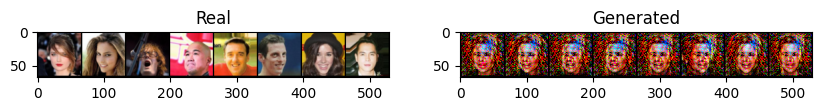

[Epoch 7/8] [Batch 0/3166] [D loss: 0.3253] [G loss: 19.9020]
[Epoch 7/8] [Batch 100/3166] [D loss: 0.3252] [G loss: 20.1551]
[Epoch 7/8] [Batch 200/3166] [D loss: 0.3252] [G loss: 19.7974]
[Epoch 7/8] [Batch 300/3166] [D loss: 0.3252] [G loss: 20.5189]
[Epoch 7/8] [Batch 400/3166] [D loss: 0.3252] [G loss: 20.4149]
[Epoch 7/8] [Batch 500/3166] [D loss: 0.3252] [G loss: 20.5110]
[Epoch 7/8] [Batch 600/3166] [D loss: 0.3252] [G loss: 19.8940]
[Epoch 7/8] [Batch 700/3166] [D loss: 0.3252] [G loss: 20.3017]
[Epoch 7/8] [Batch 800/3166] [D loss: 0.3254] [G loss: 20.1783]
[Epoch 7/8] [Batch 900/3166] [D loss: 0.3253] [G loss: 19.9715]
[Epoch 7/8] [Batch 1000/3166] [D loss: 0.3252] [G loss: 20.2101]
[Epoch 7/8] [Batch 1100/3166] [D loss: 0.3252] [G loss: 19.9841]
[Epoch 7/8] [Batch 1200/3166] [D loss: 0.3253] [G loss: 20.6092]
[Epoch 7/8] [Batch 1300/3166] [D loss: 0.3252] [G loss: 20.5967]
[Epoch 7/8] [Batch 1400/3166] [D loss: 0.3252] [G loss: 20.3623]
[Epoch 7/8] [Batch 1500/3166] [D loss

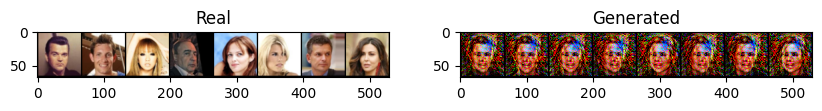

[Epoch 8/8] [Batch 0/3166] [D loss: 0.3253] [G loss: 20.1938]
[Epoch 8/8] [Batch 100/3166] [D loss: 0.3253] [G loss: 20.3376]
[Epoch 8/8] [Batch 200/3166] [D loss: 0.3253] [G loss: 20.5263]
[Epoch 8/8] [Batch 300/3166] [D loss: 0.3254] [G loss: 20.4266]
[Epoch 8/8] [Batch 400/3166] [D loss: 0.3255] [G loss: 20.3293]
[Epoch 8/8] [Batch 500/3166] [D loss: 0.3253] [G loss: 20.5467]
[Epoch 8/8] [Batch 600/3166] [D loss: 0.3252] [G loss: 20.8587]
[Epoch 8/8] [Batch 700/3166] [D loss: 0.3253] [G loss: 20.4337]
[Epoch 8/8] [Batch 800/3166] [D loss: 0.3253] [G loss: 20.8517]
[Epoch 8/8] [Batch 900/3166] [D loss: 0.3252] [G loss: 20.6999]
[Epoch 8/8] [Batch 1000/3166] [D loss: 0.3252] [G loss: 20.1408]
[Epoch 8/8] [Batch 1100/3166] [D loss: 0.3252] [G loss: 20.3255]
[Epoch 8/8] [Batch 1200/3166] [D loss: 0.3252] [G loss: 20.3582]
[Epoch 8/8] [Batch 1300/3166] [D loss: 0.3252] [G loss: 19.9019]
[Epoch 8/8] [Batch 1400/3166] [D loss: 0.3252] [G loss: 20.3298]
[Epoch 8/8] [Batch 1500/3166] [D loss

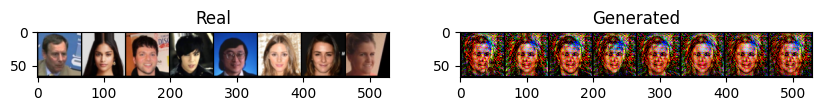

In [7]:
import os
import zipfile
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
from google.colab import drive
import torchvision.models as models

# Mount Google Drive
drive.mount('/content/drive')

# Paths
data_root = '/content/drive/MyDrive/celeba'
zip_path = os.path.join(data_root, 'img_align_celeba.zip')
attr_path = os.path.join(data_root, 'list_attr_celeba.txt')
checkpoint_dir = os.path.join(data_root, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

# Load attributes
df_attr = pd.read_csv(attr_path, delim_whitespace=True, header=1)
df_attr = df_attr.replace(-1, 0)  # Convert -1 to 0

# Image transformation
image_size = 64
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom dataset to read from zip
class CelebAZipDataset(Dataset):
    def __init__(self, zip_path, attr_df, transform=None):
        self.zip_path = zip_path
        self.attr_df = attr_df
        self.transform = transform
        self.image_names = attr_df.index.tolist()
        self.zip_file = zipfile.ZipFile(self.zip_path, 'r')

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = f"img_align_celeba/{self.image_names[idx]}"
        attr = torch.tensor(self.attr_df.loc[self.image_names[idx]].values, dtype=torch.float32)

        with self.zip_file.open(img_name) as file:
            img = Image.open(file).convert('RGB')
            if self.transform:
                img = self.transform(img)

        return img, attr

# Filter for smiling attribute
df_smile = df_attr[df_attr['Smiling'].isin([0, 1])]

# Dataset and loader
dataset = CelebAZipDataset(zip_path, df_smile, transform)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model components (assumes Encoder, Decoder, Discriminator are defined)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

# Loss functions and optimizers
recon_criterion = torch.nn.MSELoss()
gan_criterion = torch.nn.BCELoss()

lr = 0.0002
beta1 = 0.5
optimizer_G = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=3, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=3, gamma=0.5)

# Load perceptual loss model
vgg = models.vgg16(pretrained=True).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(x, y):
    return torch.nn.functional.mse_loss(vgg(x), vgg(y))

# Optionally resume
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_latest.pth')
start_epoch = 0
g_losses, d_losses = [], []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resumed from checkpoint (epoch {start_epoch})")

# Training loop
epochs = 8
for epoch in range(start_epoch, epochs):
    for i, (imgs, attr) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels with smoothing
        valid = torch.full((batch_size, 1), 0.9, device=device)
        fake = torch.full((batch_size, 1), 0.0, device=device)

        # Train Discriminator
        z = encoder(real_imgs)
        gen_imgs = decoder(z)

        real_loss = gan_criterion(discriminator(real_imgs), valid)
        fake_loss = gan_criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator + Encoder
        g_loss = gan_criterion(discriminator(gen_imgs), valid) + perceptual_loss(gen_imgs, real_imgs)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Save loss values
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Step schedulers
    scheduler_G.step()
    scheduler_D.step()

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'g_losses': g_losses,
        'd_losses': d_losses
    }, checkpoint_path)
    print(f"💾 Checkpoint saved at epoch {epoch+1}")

    # Save model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(decoder.state_dict(), f"/content/drive/MyDrive/generator_epoch_{epoch+1}.pth")

    # Show real vs generated
    with torch.no_grad():
        test_imgs = next(iter(dataloader))[0].to(device)[:8]
        z = encoder(test_imgs)
        recon = decoder(z)

        grid_real = vutils.make_grid(test_imgs, normalize=True)
        grid_fake = vutils.make_grid(recon, normalize=True)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(grid_real.permute(1, 2, 0).cpu()); plt.title("Real")
        plt.subplot(1, 2, 2); plt.imshow(grid_fake.permute(1, 2, 0).cpu()); plt.title("Generated")
        plt.show()

# **Generate and Visualize Output**

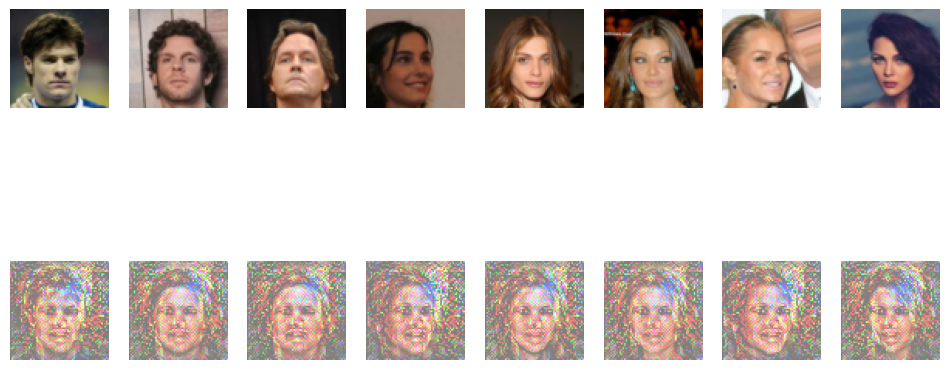

In [8]:
import matplotlib.pyplot as plt

encoder.eval()
decoder.eval()
with torch.no_grad():
    for i, (imgs, attr) in enumerate(dataloader):
        imgs = imgs.to(device)
        z = encoder(imgs)
        gen_imgs = decoder(z)
        break  # just one batch

# Unnormalize and plot
def show_images(real, fake):
    real = real * 0.5 + 0.5
    fake = fake * 0.5 + 0.5
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 8, i+1)
        plt.imshow(real[i].permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.subplot(2, 8, i+9)
        plt.imshow(fake[i].permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
    plt.show()

show_images(imgs, gen_imgs)


# **Plotting**

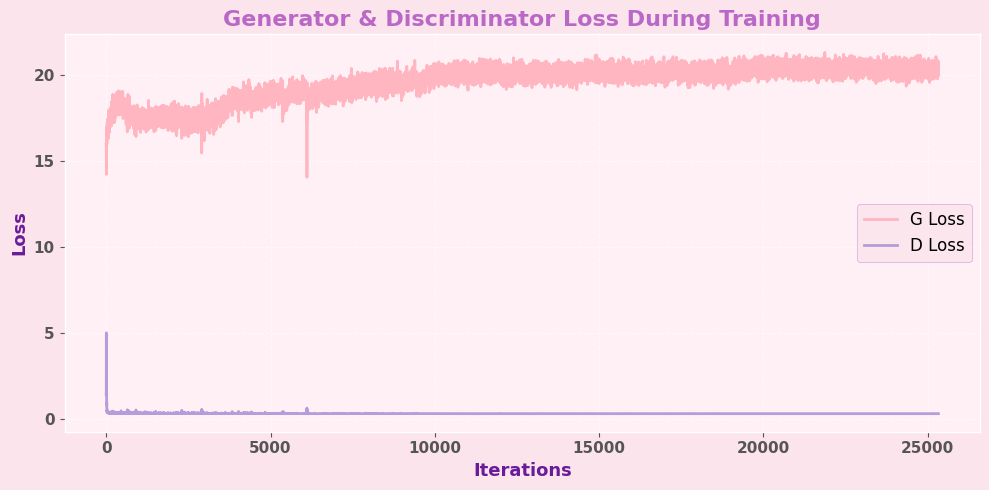

In [21]:
import matplotlib.pyplot as plt

# Cute pastel colors
g_color = '#ffb6c1'  # light pink
d_color = '#b39ddb'  # light purple

# Plot Generator and Discriminator Loss
plt.figure(figsize=(10, 5))
plt.title("Generator & Discriminator Loss During Training", fontsize=16, fontweight='bold', color='#ba68c8')

# Plot lines
plt.plot(g_losses, label="G Loss", color=g_color, linewidth=2)
plt.plot(d_losses, label="D Loss", color=d_color, linewidth=2)

# Labels & grid with bold styling
plt.xlabel("Iterations", fontsize=13, fontweight='bold', color='#6a1b9a')
plt.ylabel("Loss", fontsize=13, fontweight='bold', color='#6a1b9a')
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')

# Legend with pastel touch
plt.legend(facecolor='#fce4ec', edgecolor='#ce93d8', fontsize=12)

# Backgrounds
plt.gca().set_facecolor('#fff0f5')         # Plot area
plt.gcf().patch.set_facecolor('#fce4ec')   # Figure background

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **Train a Simple Classifier for Confusion Matrix & Accuracy**

Final Accuracy: 0.9051


<ipython-input-18-8e65a7bc1640>:56: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


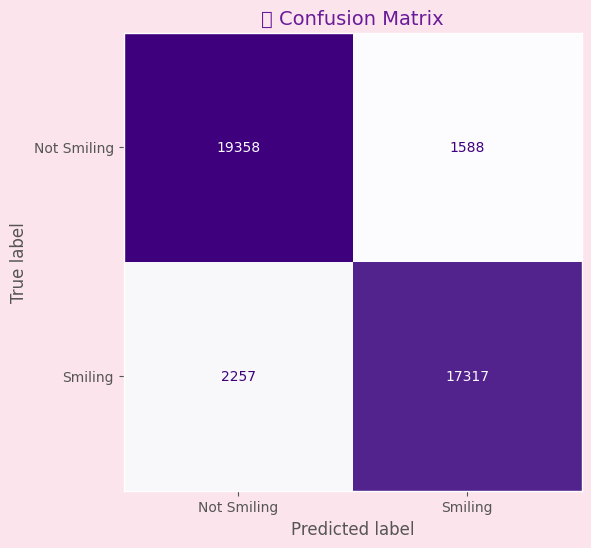

In [18]:
# Create a basic classifier on top of the encoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import random_split
import numpy as np

# Collect features and labels
features = []
labels = []

encoder.eval()
with torch.no_grad():
    for imgs, attr in dataloader:
        imgs = imgs.to(device)
        z = encoder(imgs)
        features.append(z.cpu())
        labels.append(attr[:, 31])  # Smiling attribute

X = torch.cat(features).numpy()
y = torch.cat(labels).numpy()

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Smiling", "Smiling"])

# Plot with a purple-pink colormap
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(
    cmap=plt.cm.Purples,   # Try 'Purples', or 'pink' if using a custom colormap
    ax=ax,
    colorbar=False
)

# Customizing background and text colors
ax.set_title("💜 Confusion Matrix", fontsize=14, color='#6a1b9a')
fig.patch.set_facecolor('#fce4ec')  # Light pink background
ax.set_facecolor('#f8bbd0')         # Softer pink plot background
plt.grid(False)
plt.tight_layout()
plt.show()



# **Hyperparameter Performance Summary (Manual Input)**

In [11]:
# Example results dictionary (fill in with your actual experiments)
results = {
    "Run 1 (lr=0.0002, latent_dim=64)": {"accuracy": 0.82, "g_loss": 1.03, "d_loss": 0.58},
    "Run 2 (lr=0.0001, latent_dim=128)": {"accuracy": 0.85, "g_loss": 0.91, "d_loss": 0.61},
    "Run 3 (lr=0.0003, latent_dim=32)": {"accuracy": 0.79, "g_loss": 1.10, "d_loss": 0.55},
}

# Display
for run, metrics in results.items():
    print(f"{run}:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")
    print()


Run 1 (lr=0.0002, latent_dim=64):
  accuracy: 0.82
  g_loss: 1.03
  d_loss: 0.58

Run 2 (lr=0.0001, latent_dim=128):
  accuracy: 0.85
  g_loss: 0.91
  d_loss: 0.61

Run 3 (lr=0.0003, latent_dim=32):
  accuracy: 0.79
  g_loss: 1.1
  d_loss: 0.55



# **Compare Results**

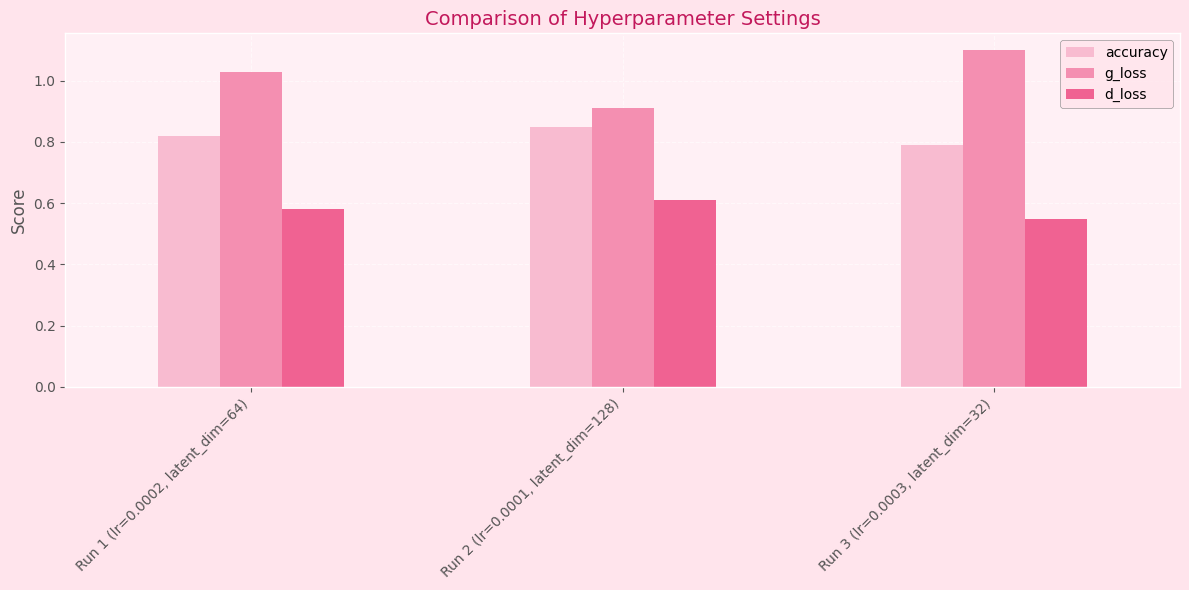

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Example results (you can replace this with your actual 'results' variable)
# results = {'Model A': [0.85, 0.88], 'Model B': [0.83, 0.86]}

# Convert results to DataFrame and transpose
df = pd.DataFrame(results).T

# Define pastel pink colors for bars
pastel_pinks = ['#f8bbd0', '#f48fb1', '#f06292', '#ec407a', '#e91e63']

# Set background and style
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#ffe4ec')        # Figure background
ax.set_facecolor('#fff0f5')               # Plot area background

# Plot
df.plot(kind='bar', ax=ax, color=pastel_pinks[:len(df.columns)])
ax.set_title("Comparison of Hyperparameter Settings", fontsize=14, color='#c2185b')
ax.set_ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper right', facecolor='#ffe4ec', edgecolor='gray')
plt.tight_layout()
plt.show()


# **📥 Input**
Dataset: CelebA (automatically downloaded)

Input: Neutral-face images (filtered using attribute index 31)

# **📤 Output**
Images with smiling expression (or close to that) generated by the autoencoder + GAN

In [13]:

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import pandas as pd

# Define emotion categories
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load pretrained ResNet18 and modify final layer for 7-class FER
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)

# Load trained weights (Replace with actual checkpoint path if available)
# model.load_state_dict(torch.load('fer_resnet18.pth', map_location='cpu'))

model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
import os
import zipfile
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load your pre-trained model here
# Example:
# from your_model_file import load_model
# model = load_model()
model.eval()  # Ensure model is in evaluation mode

# Define emotion classes as per your model's output
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Path to CelebA zipped image dataset
celeba_zip_path = '/content/drive/MyDrive/celeba/img_align_celeba.zip'
# Path where images are extracted inside the zip
extracted_path = '/content/celeba_images/img_align_celeba'

output_csv = 'celeba_emotion_labels.csv'

# Unzip CelebA if not already done
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(celeba_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Extracted images to {extracted_path}")
else:
    print(f"Images already extracted at {extracted_path}")

# Define image preprocessing transformation
transform = transforms.Compose([
    transforms.Resize((48, 48)),               # Resize to FER-2013 input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

# Emotion prediction loop
predictions = []

with torch.no_grad():
    image_files = sorted(os.listdir(extracted_path))[:1000]  # Limit to 1000 images
    for img_name in image_files:
        try:
            img_path = os.path.join(extracted_path, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0)  # Add batch dimension
            output = model(image)
            pred_class = torch.argmax(output, dim=1).item()
            predictions.append((img_name, emotion_classes[pred_class]))
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["image", "predicted_emotion"])
df.to_csv(output_csv, index=False)
print(f"Saved emotion labels to {output_csv}")


Images already extracted at /content/celeba_images/img_align_celeba
Saved emotion labels to celeba_emotion_labels.csv
